In [1]:
import sys
sys.path.append("../src")

import os
import concurrent.futures

import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import LinearSegmentedColormap

from utils import (
    WSIDataset, get_args, save_results, 
    extract_coords, merge_patches, adjust_coords,
    get_save_dirs, get_model, ResNet, 
    SwinTransformer, BaseMIL, AttentionBasedMIL,
)

/Users/ericmonzon/mambaforge/envs/histology/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_dir = os.path.join("..", "src", "configs", "attention-vis-config.json")
args = get_args(config_dir)
mil = True if args["model"] == "attention-mil" else False

raw_embedding_dir = os.path.join("..", "..", "raw-data", "embeddings", "experiment-0", "UNI")
raw_patch_dir = os.path.join("..", "..", "raw-data", "patches", "experiment-0")
root_data_dir = os.path.join("..", "data", args["feature_extractor"], args["embedding_type"])
base_model_dir, base_save_dir = get_save_dirs(args, mode="inference")
num_splits = len(os.listdir(root_data_dir))

In [3]:
trial_dir = os.path.join(root_data_dir, f"split-1")
inference_dir = os.path.join(trial_dir, "test")

label_dir = os.path.join("..", "data", "labels.csv")
model_dir = os.path.join(base_model_dir, f"split-1")
save_dir = os.path.join(base_save_dir, f"split-1")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inference_dataset = WSIDataset(inference_dir, label_dir, mil, args["pad"], False, args["embedding_type"], args["target_shape"])
inference_loader = DataLoader(inference_dataset, batch_size=args["batch_size"], shuffle=False)

In [5]:
model, save_base_name = get_model(args)
model = model.to(device)

weights_dir = os.path.join(model_dir, f"{save_base_name}-{args['weights']}")
weights = torch.load(weights_dir, map_location=torch.device(device), weights_only=True)
model.load_state_dict(weights)
model = model.eval()

In [6]:
wsi_embedding, target, patient_id = next(iter(inference_loader))

patient_parquet = pd.read_parquet(os.path.join(raw_embedding_dir, f"{patient_id[0]}.parquet")).drop("embedding", axis=1)

In [7]:
patient_id

('14917C',)

In [8]:
wsi_embedding = wsi_embedding.to(device)
target = target.to(device)

In [9]:
mil

True

In [10]:
with torch.inference_mode():
    if mil: 
        logits, attention_weights = model(wsi_embedding)

    else: 
        logits = model(wsi_embedding)

In [11]:
attention_weights.shape

torch.Size([1, 33625, 1])

In [11]:
def min_max_scale(attention_col):
    return (attention_col - attention_col.min()) / (attention_col.max() - attention_col.min())

def read_image(img_path, size):
    img = cv2.imread(img_path)
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def multithread_read_img(img_paths, size):
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(executor.map(read_image, img_paths, [size] * len(img_paths)), total=len(img_paths), desc="processing images"))

    return results

In [12]:
patch_shape = (64, 64)

patient_parquet["adjusted_coords"] = adjust_coords(patient_parquet["processed_coords"].tolist(), 224, patch_shape[0])
patient_parquet["img_paths"] = patient_parquet["coords"].map(lambda x: os.path.join(raw_patch_dir, patient_id[0], f"{x}.png"))
patient_parquet["img"] = multithread_read_img(patient_parquet["img_paths"], patch_shape)

patient_parquet["attention"] = attention_weights.squeeze().cpu().numpy()
patient_parquet["attention"] = min_max_scale(patient_parquet["attention"])
patient_parquet["attention"] = patient_parquet["attention"].map(lambda x: np.expand_dims(np.ones(patch_shape) * x, axis=-1))

patient_parquet.head()

processing images: 100%|██████████| 33625/33625 [00:28<00:00, 1198.06it/s]


,coords,processed_coords,adjusted_coords,img_paths,img,attention
0,patch-18816-19040-19712-19936,"[18816, 19040, 19712, 19936]","[5376, 5440, 5632, 5696]",../../raw-data/patches/experiment-0/14917C/pat...,"[[[151, 157, 155], [145, 154, 144], [146, 148,...","[[[0.014306719414889812], [0.01430671941488981..."
1,patch-19040-19264-19712-19936,"[19040, 19264, 19712, 19936]","[5440, 5504, 5632, 5696]",../../raw-data/patches/experiment-0/14917C/pat...,"[[[154, 163, 159], [151, 160, 159], [151, 157,...","[[[0.01567319594323635], [0.01567319594323635]..."
2,patch-19264-19488-19712-19936,"[19264, 19488, 19712, 19936]","[5504, 5568, 5632, 5696]",../../raw-data/patches/experiment-0/14917C/pat...,"[[[154, 160, 163], [151, 157, 163], [149, 157,...","[[[0.0134578887373209], [0.0134578887373209], ..."
3,patch-19488-19712-19712-19936,"[19488, 19712, 19712, 19936]","[5568, 5632, 5632, 5696]",../../raw-data/patches/experiment-0/14917C/pat...,"[[[146, 149, 151], [142, 145, 145], [138, 145,...","[[[0.01555197685956955], [0.01555197685956955]..."
4,patch-19712-19936-19712-19936,"[19712, 19936, 19712, 19936]","[5632, 5696, 5632, 5696]",../../raw-data/patches/experiment-0/14917C/pat...,"[[[137, 143, 142], [134, 140, 139], [130, 138,...","[[[0.015189012512564659], [0.01518901251256465..."


In [13]:
attention_weights_np = attention_weights.squeeze().numpy()

attention_weights_np = (attention_weights_np - attention_weights_np.min()) / (attention_weights_np.max() - attention_weights_np.min())

attention_weights_np

array([0.01430672, 0.0156732 , 0.01345789, ..., 0.02806681, 0.03288854,
       0.03164428], dtype=float32)

In [17]:
fig = px.histogram(
    attention_weights_np,
    nbins=30,
    histnorm="density",  # for density normalization
)

fig.update_traces(marker=dict(color="blue", opacity=0.6), showlegend=False)
fig.update_layout(
    title="Histogram of Attention Weights",
    xaxis_title="Attention Weight",
    yaxis_title="Density"
)

fig.show()

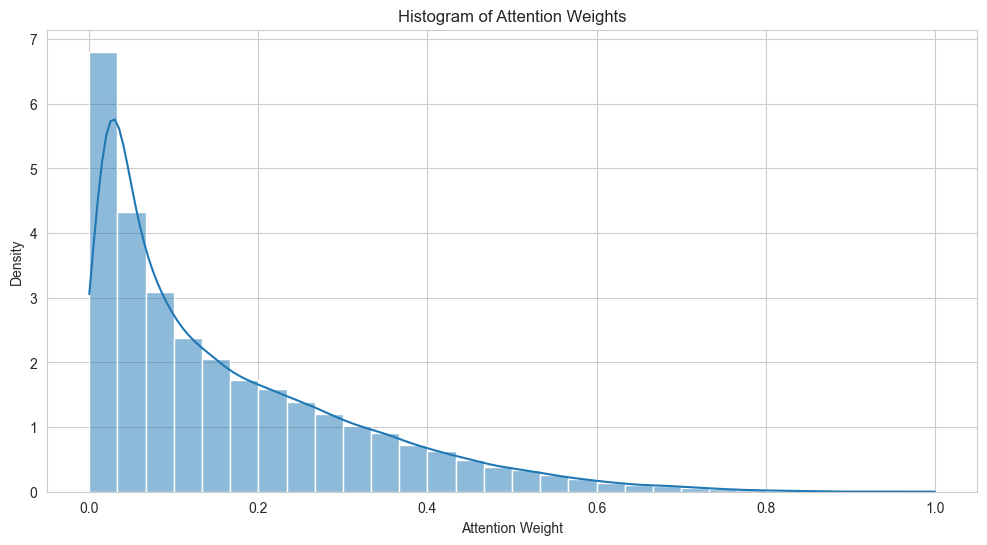

In [20]:
# CE

plt.figure(figsize=(12, 6))
sns.histplot(attention_weights_np.flatten(), bins=30, kde=True, stat="density")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

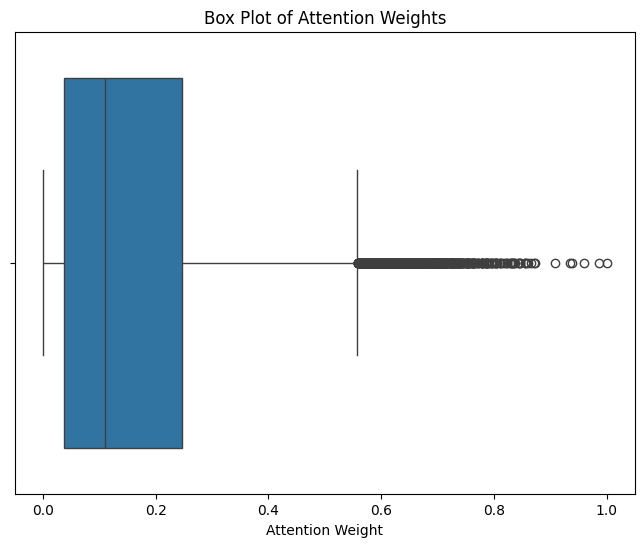

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=attention_weights_np.flatten())
plt.title("Box Plot of Attention Weights")
plt.xlabel("Attention Weight")
plt.show()

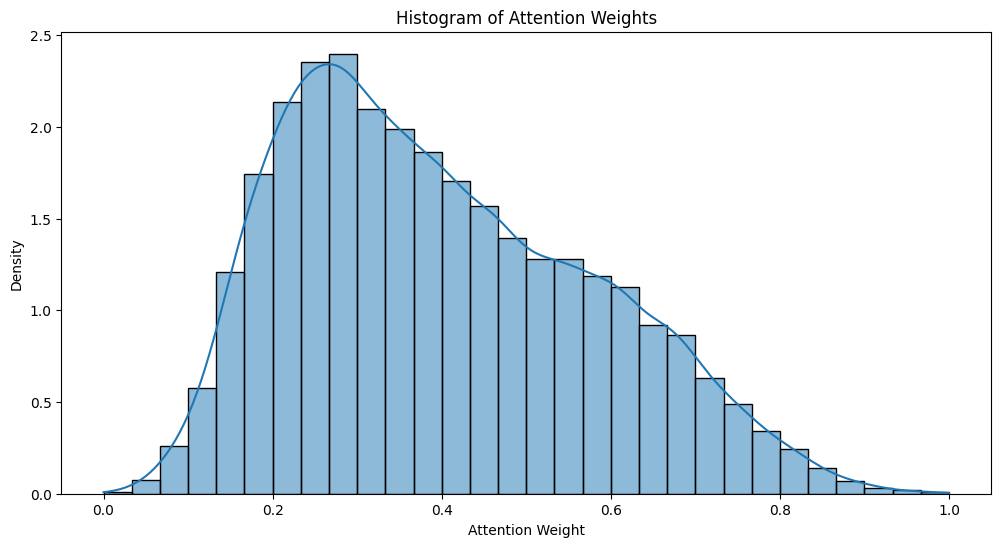

In [20]:
# FL

plt.figure(figsize=(12, 6))
sns.histplot(attention_weights_np.flatten(), bins=30, kde=True, stat="density")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

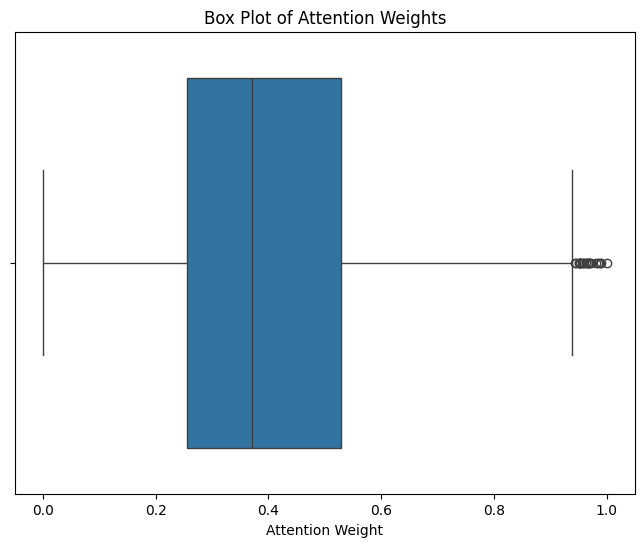

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=attention_weights_np.flatten())
plt.title("Box Plot of Attention Weights")
plt.xlabel("Attention Weight")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df, x="Attention Weight", bins=30, kde=True, stat="density")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

In [12]:
attention_weights_np = attention_weights.squeeze().numpy()

np.percentile(attention_weights_np, [75, 25])

array([3.13458913e-05, 2.79730339e-05])

In [20]:
attention_weights_np.std()

np.float32(2.2131405e-06)

In [33]:
attention_weights_np = attention_weights.squeeze().numpy()

np.percentile(attention_weights_np, [75, 25])

array([4.29837019e-05, 9.83997688e-06])

In [17]:
merged_attention = merge_patches(patient_parquet["attention"].tolist(), patient_parquet["adjusted_coords"].tolist(), target_patch_size=patch_shape[0])
merged_img = merge_patches(patient_parquet["img"].tolist(), patient_parquet["adjusted_coords"].tolist(), target_patch_size=patch_shape[0]).astype("uint8")

In [18]:
modified_cmap = LinearSegmentedColormap.from_list(
    "modified_cmap", 
    [(0, "black")] + 
    [(i, plt.cm.jet(i)) for i in np.linspace(0, 1, 256)]
    )

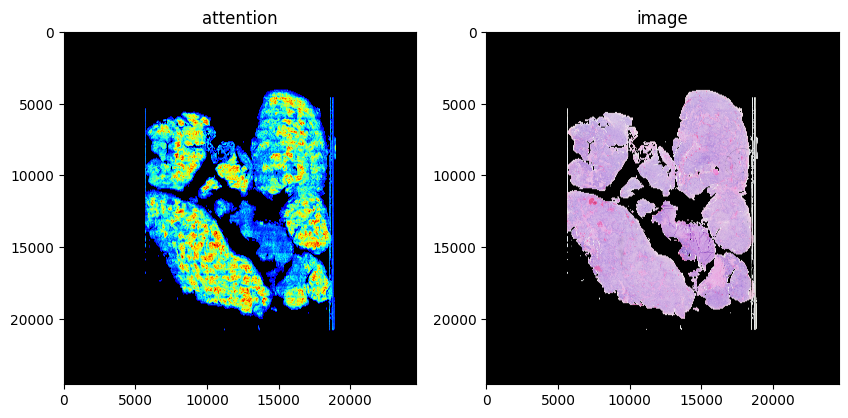

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))

axes[0].imshow(merged_attention, cmap=modified_cmap)
axes[0].set_title("attention")

axes[1].imshow(merged_img)
axes[1].set_title("image")

plt.show()

In [12]:
merged_attention_bgr = cv2.applyColorMap((merged_attention * 255).astype(np.uint8), cv2.COLORMAP_TURBO)
merged_img_bgr = cv2.cvtColor(merged_img, cv2.COLOR_RGB2BGR)

alpha = 0.5

overlay = cv2.addWeighted(merged_img_bgr, 0.5, merged_attention_bgr, alpha, 0)
merged_attention_bgr[(merged_img == [0, 0, 0]).all(axis=-1)] = [0, 0 ,0]
overlay[(merged_img == [0, 0, 0]).all(axis=-1)] = [0, 0 ,0]

cv2.imwrite('overlay_output.png', overlay)

True

In [15]:
color_bar_height = 300
color_bar_width = 50
color_bar = np.zeros((color_bar_height, color_bar_width, 3), dtype=np.uint8)

for i in range(color_bar_height):
    color_value = int((i / color_bar_height) * 255)
    color = cv2.applyColorMap(np.array([[color_value]], dtype=np.uint8), cv2.COLORMAP_TURBO)[0, 0]
    color_bar[color_bar_height - i - 1, :] = color

cv2.imwrite('color_bar.png', color_bar)

True